In [1]:
import GEOparse
import pandas as pd

GEOparse.logger.set_verbosity("ERROR")

In [2]:
gse = GEOparse.get_GEO(geo='GSE116222', destdir="./data/geo_cache")

platform_id = gse.metadata['platform_id'][0]
print(f"Platform ID: {platform_id}")

Platform ID: GPL24676


In [3]:
# read gz file
import gzip

with gzip.open('./data/geo_cache/GSE116222_Expression_matrix.txt.gz', 'rt') as f:
    expr_matrix = pd.read_csv(f, sep='\t', index_col=0)

In [4]:
expression_data = expr_matrix.T

labels = expression_data.index.str.split('-').str[1].to_list()

inflammation_labels = ['UC inflamed' if x.endswith('3') else 'UC non-inflamed' if x.endswith('2') else 'Healthy' for x in labels]

In [6]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(expression_data)

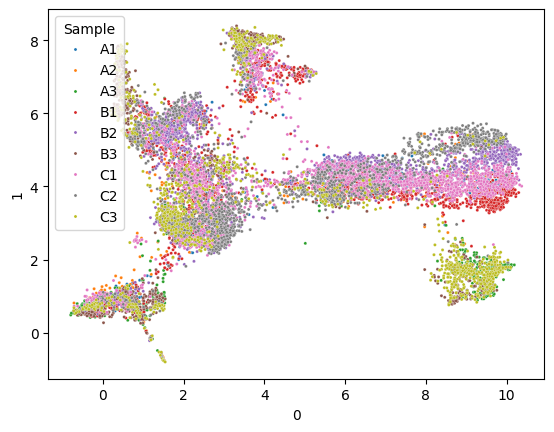

In [7]:
import seaborn as sns

plot_data = pd.concat([pd.DataFrame(embedding), pd.Series(labels).rename('Sample')], axis=1)

sns.scatterplot(data=plot_data, x=0, y=1, hue="Sample", s=5);

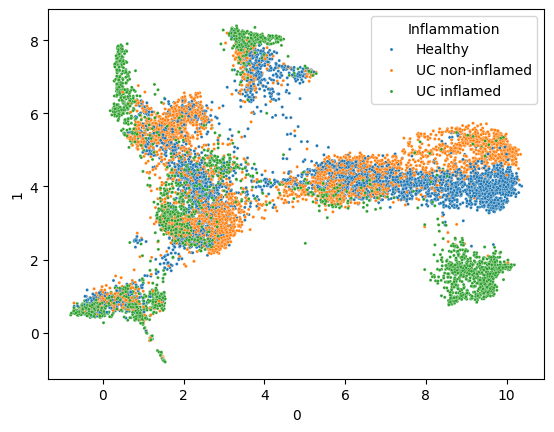

In [8]:
import seaborn as sns

plot_data = pd.concat([pd.DataFrame(embedding), pd.Series(inflammation_labels).rename('Inflammation')], axis=1)

sns.scatterplot(data=plot_data, x=0, y=1, hue="Inflammation", s=5);